In [1]:
from pathlib import Path
import pickle

import numpy as np
import pandas as pnd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sb


from helper_functions import *

# define main functions

In [2]:
def get_contents_df(files):
    
    
    results_df = [] 
    for file in files:
    
        strain_id = Path(file).stem
        strain_id = strain_id.replace('_model', '')
        if '-draft' in strain_id: 
            continue    # Skip gapseq draft models

        if file.endswith('.xml'): 
            model = cobra.io.read_sbml_model(file)
        if file.endswith('.json'): 
            model = cobra.io.load_json_model(file)


        # genes
        gids = set([g.id for g in model.genes])
        G = len(gids)
        
        # reactions (no exchanges)
        rids = set([r.id for r in model.reactions if not (len(r.metabolites)==1 and list(r.metabolites)[0].id.rsplit('_', 1)[-1] in ['e', 'e0'])])
        R = len(rids)
        
        # metabolites (without compartment)
        umids = set([m.id.rsplit('_',1)[0] for m in model.metabolites])
        uM = len(umids)
        
        # exchange reactions
        exr_ids = set([r.id for r in model.reactions if (len(r.metabolites)==1 and list(r.metabolites)[0].id.rsplit('_', 1)[-1] in ['e', 'e0'])])
        exr = len(exr_ids)
        
        # "metabolic" reactions (no exr / sink / demand / diffusions):
        metR_ids = set()
        
        # "metabolic" reactions without GPR 
        orpR_ids = set()
        for r in model.reactions: 
            if len(r.metabolites) != 1:  # exclude exr/demand/sinks
                if 'diffusion' not in r.name.lower():  # exclude diffusions
                    metR_ids.add(r.id)
                    if r.gene_reaction_rule == '':
                        orpR_ids.add(r.id)
                        
            
        results_df.append({'strain': strain_id, 'metric': 'G', 'value': gids})
        results_df.append({'strain': strain_id, 'metric': 'R', 'value': rids})
        results_df.append({'strain': strain_id, 'metric': 'uM', 'value': umids})
        results_df.append({'strain': strain_id, 'metric': 'exr', 'value': exr_ids})
        results_df.append({'strain': strain_id, 'metric': 'metR', 'value': metR_ids})
        results_df.append({'strain': strain_id, 'metric': 'orpR', 'value': orpR_ids})
            
        print('▯', end='')  # loading bar

    results_df = pnd.DataFrame.from_records(results_df)
    return results_df

# main run

In [3]:
%%capture --no-stdout


for dataset in ['01_klebsiella', '02_ralstonia', '03_pseudomonas']:
    
    df_list = []
    for tool in ['reference', 'gempipe', 'gempipe_rf', 'carveme', 'gapseq', 'bactabolize']:
        
        if tool=='reference' and dataset=='01_klebsiella': 
            globber = '01_klebsiella/reference/iYL1228_edited.xml'
        if tool=='reference' and dataset=='02_ralstonia': 
            globber = '02_ralstonia/reference/iRP1476_edited.xml'
        if tool=='reference' and dataset=='03_pseudomonas': 
            globber = '03_pseudomonas/reference/iJN1463_edited.xml'
            
        if tool == 'gempipe': 
            globber = f'{dataset}/tools_runs/gempipe/output/strain_models_gf/*.json'
        if tool == 'gempipe_rf': 
            globber = f'{dataset}/tools_runs/gempipe_rf/output/strain_models_gf/*.json'
        if tool == 'carveme': 
            globber = f'{dataset}/tools_runs/carveme/output/*.xml'
        if tool == 'bactabolize': 
            globber = f'{dataset}/tools_runs/bactabolize/gapfilled/*.json'
        if tool == 'gapseq': 
            globber = f'{dataset}/tools_runs/gapseq/output/*/*.xml'
        
        
        print(dataset, tool, end=': ') 
        res = parallelizer(globber, get_contents_df, nthreads=37)
        print()
        
        res['tool'] = tool
        res['dataset'] = dataset
        df_list.append(res)
        
    df_dataset = pnd.concat(df_list)
    df_dataset.to_csv(f'{dataset}/tables/contents.csv')
    

01_klebsiella reference: ▯
01_klebsiella gempipe: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯
01_klebsiella gempipe_rf: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯
01_klebsiella carveme: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯
01_klebsiella gapseq: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯
01_klebsiella bactabolize: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯
02_ralstonia reference: ▯
02_ralstonia gempipe: ▯▯▯▯▯▯▯▯▯▯▯
02_ralstonia gempipe_rf: ▯▯▯▯▯▯▯▯▯▯▯
02_ralstonia carveme: ▯▯▯▯▯▯▯▯▯▯▯
02_ralstonia gapseq: ▯▯▯▯▯▯▯▯▯▯▯
02_ralstonia bactabolize: ▯▯▯▯▯▯▯▯▯▯▯
03_pseudomonas reference: ▯
03_pseudomonas gempipe: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯
03_pseudomonas gempipe_rf: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯
03_pseudomonas carveme: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯
03_pseudomonas gapseq: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯
03_pseudomonas bactabolize: ▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯▯


# comput set lengths

In [4]:
contents_01 = pnd.read_csv(f'01_klebsiella/tables/contents.csv', index_col=0)
contents_02 = pnd.read_csv(f'02_ralstonia/tables/contents.csv', index_col=0)
contents_03 = pnd.read_csv(f'03_pseudomonas/tables/contents.csv', index_col=0)
contents_all = pnd.concat([contents_01, contents_02, contents_03])
contents_all = contents_all.reset_index(drop=True)


# 'value' col is str after reading; convert back to set:
for index, row in contents_all.iterrows(): 
    contents_all.loc[index, 'value'] = eval(contents_all.loc[index, 'value'])


# compute set lengths
contents_all['value_len'] = None
for index, row in contents_all.iterrows(): 
    value_len = len(contents_all.loc[index, 'value'])
    contents_all.loc[index, 'value_len'] = value_len

# gapseq conversion with metanetx

In [5]:
with open('seed_mappings/seed_to_others_extended_M.pickle', 'rb') as file:
    seed_mappings_M = pickle.load(file)
with open('seed_mappings/seed_to_others_extended_R.pickle', 'rb') as file:
    seed_mappings_R = pickle.load(file)

    
for index, row in contents_all.iterrows(): 
    
    if row['tool']=='gapseq':
        if row['metric']=='G': 
            continue  # there is no translation for gene IDs
            
        ids = contents_all.loc[index, 'value']
        tranlated_ids = set()
        for i in ids:
            
            if row['metric'] in ['R', 'metR', 'orpR']: 
                currid = i.rsplit('_', 1)[0]
                if currid in seed_mappings_R.keys():
                    curr_trans = seed_mappings_R[currid]['bigg.reaction']
                    curr_trans = [k for k in curr_trans if k.startswith('R_') == False]
            
            elif row['metric'] == 'uM': 
                currid = i
                if currid in seed_mappings_M.keys():
                    curr_trans = seed_mappings_M[currid]['bigg.metabolite']
            
            elif row['metric'] == 'exr': 
                currid = i.rsplit('_', 1)[0][3:]
                if currid in seed_mappings_M.keys():
                    curr_trans = seed_mappings_M[currid]['bigg.metabolite']
                    curr_trans = [f'EX_{k}_e' for k in curr_trans]
            
            for k in curr_trans: 
                tranlated_ids.add(k)
            
        contents_all.at[index, 'value'] = tranlated_ids

# reference intersection

In [6]:
contents_all['value_inter'] = None
contents_all['value_len_inter'] = 0

for index, row in contents_all.iterrows(): 
    if row['metric'] != 'G':  # genes are treated separately
         
        reference = contents_all[
            (contents_all['tool']=='reference') & \
            (contents_all['dataset']==row['dataset']) & \
            (contents_all['metric']==row['metric']) \
        ]['value'].iloc[0]
        intersection = reference.intersection(contents_all.loc[index, 'value'])

        contents_all.at[index, 'value_inter'] = intersection
        contents_all.at[index, 'value_len_inter'] = len(intersection)
        
        

## G intersection

In [7]:
dataset_to_dict = {
    '01_klebsiella': pickle.load(open('01_klebsiella/tools_runs/gempipe/working/brh/iYL1228_edited.xml.refgid_to_clusters.pickle', 'rb')),
    '02_ralstonia': pickle.load(open('02_ralstonia/tools_runs/gempipe/working/brh/iRP1476_edited.xml.refgid_to_clusters.pickle', 'rb')),
    '03_pseudomonas': pickle.load(open('03_pseudomonas/tools_runs/gempipe/working/brh/iJN1463_edited.xml.refgid_to_clusters.pickle', 'rb')),
}
dataset_to_pam = {
    '01_klebsiella': pnd.read_csv('01_klebsiella/tools_runs/gempipe/output/pam.csv', index_col=0),
    '02_ralstonia': pnd.read_csv('02_ralstonia/tools_runs/gempipe/output/pam.csv', index_col=0),
    '03_pseudomonas': pnd.read_csv('03_pseudomonas/tools_runs/gempipe/output/pam.csv', index_col=0),
}



In [8]:
def ref_gid_is_present(equivalent_clusters, pam_column, gids_modeled_by_tool):
    # example call: 
    # is_present(dataset_to_dict['01_klebsiella']['KPN_04097'],  dataset_to_pam['01_klebsiella']['Kp_SB612'], gids_modeled_by_tool)
    # dataset_to_dict['01_klebsiella']['KPN_04097']: gives a set of clusters corresponding to this reference gene
    # dataset_to_pam['01_klebsiella']['Kp_SB612']: gives strain-specific genes for each cluster
    # gids_modeled_by_tool: gives strain-specific genes modeled by the tool.
    
    
    found = False
    for cluster in equivalent_clusters: 
        if type(pam_column[cluster]) != float:
            for cds in pam_column[cluster].split(';'):
                
                if cds in gids_modeled_by_tool:
                    found = True
                    
    return found

In [9]:

for index, row in contents_all.iterrows(): 
    if row['metric'] == 'G': 
        
        reference_gids = contents_all[
            (contents_all['tool']=='reference') & \
            (contents_all['dataset']==row['dataset']) & \
            (contents_all['metric']==row['metric']) \
        ]['value'].iloc[0]  
        
        if row['tool'] == 'reference': 
            contents_all.at[index, 'value_len_inter'] = len(reference_gids)
            continue  
        
        cnt = 0
        for ref_gid in reference_gids:
            if ref_gid in dataset_to_dict[row['dataset']].keys():
                if ref_gid_is_present(
                    equivalent_clusters = dataset_to_dict[row['dataset']][ref_gid], 
                    pam_column = dataset_to_pam[row['dataset']][row['strain']],
                    gids_modeled_by_tool = row['value']
                ):
                    cnt += 1
            
        contents_all.at[index, 'value_len_inter'] = cnt
        

# plot intersection G/R/uM/exr

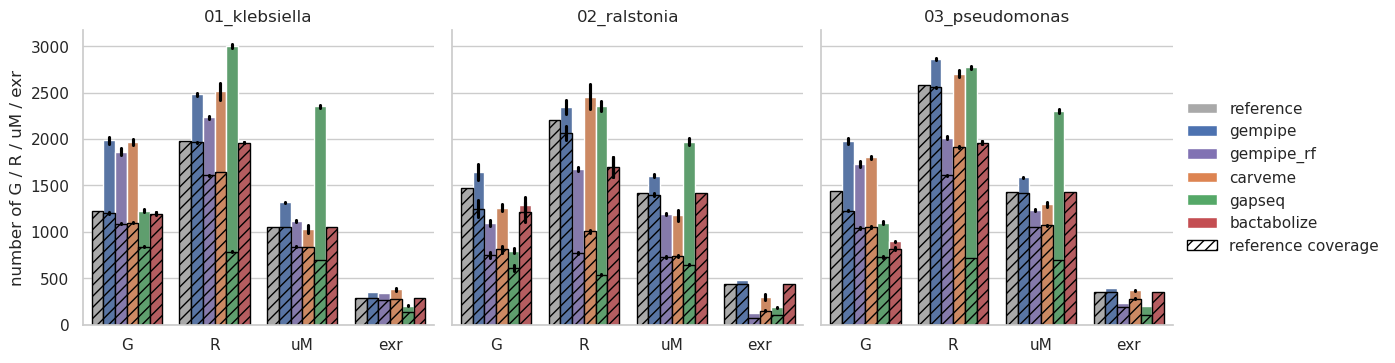

In [10]:
df = contents_all[contents_all['metric'].isin(['G','R','uM','exr'])]


sb.set_theme(style="whitegrid")


palette1 = {'reference': 'darkgrey', 'gempipe': 'C0', 'gempipe_rf': 'C4', 'carveme': 'C1', 'gapseq': 'C2', 'bactabolize': 'C3'}
g = sb.FacetGrid(df, col="dataset", height=4)
g = g.map_dataframe(sb.barplot, x='metric', y='value_len', hue='tool', palette=palette1, edgecolor='white', errorbar='sd', err_kws={'color': 'black'})
g = g.map_dataframe(sb.barplot, x='metric', y='value_len_inter', hue='tool', palette=palette1, edgecolor='black', errorbar='sd', err_kws={'color': 'black'})


for dataset in g.axes:
    for ax in dataset:
        for bars in ax.containers[int(len(ax.containers)/2):]:
            for bar in bars:
                bar.set_hatch('///')

g.set_axis_labels('', 'number of G / R / uM / exr')


# custom legend: 
plt.legend()
patches = [Patch(facecolor=value, edgecolor='white', label=key) for key, value in palette1.items()]
hatched_patch = Patch(facecolor='none', edgecolor='black', hatch='///', label='reference coverage')
patches = patches + [hatched_patch]
legend = plt.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_frame_on(False)


axes = g.axes.flatten()
axes[0].set_title("01_klebsiella")
axes[1].set_title("02_ralstonia")
axes[2].set_title("03_pseudomonas")

g

# correlation matrix (R)

In [11]:

df = contents_all[contents_all['metric']=='R']
corr_matrix = []

# execute a tool1 VS tool2:
for dataset in df['dataset'].unique():
    
    df_dataset = df[df['dataset']==dataset]
    
    for tool1 in df_dataset['tool'].unique():
        for tool2 in df_dataset['tool'].unique():

            all_strains = []

            # for each strain, excluding the reference model:
            for strain in df_dataset[df_dataset['tool']!='reference']['strain'].unique():


                # define the 2 set for which to compute jaccard:
                if tool1=='reference':
                    set1 = df_dataset[df_dataset['tool']=='reference']['value'].iloc[0]
                else:
                    set1 = df_dataset[(df_dataset['tool']==tool1) & (df_dataset['strain']==strain)]['value'].iloc[0]

                if tool2=='reference':
                    set2 = df_dataset[df_dataset['tool']=='reference']['value'].iloc[0]
                else:
                    set2 = df_dataset[(df_dataset['tool']==tool2) & (df_dataset['strain']==strain)]['value'].iloc[0]


                jaccard = len(set1.intersection(set2)) / len(set1.union(set2))
                all_strains.append(jaccard)

            mean_jaccard = sum(all_strains)/len(all_strains)
            corr_matrix.append({'dataset': dataset, 'tool1': tool1, 'tool2': tool2, 'value': mean_jaccard})

            
corr_matrix = pnd.DataFrame.from_records(corr_matrix)
corr_matrix

,dataset,tool1,tool2,value
0,01_klebsiella,reference,reference,1.000000
1,01_klebsiella,reference,gempipe,0.788825
2,01_klebsiella,reference,gempipe_rf,0.619189
3,01_klebsiella,reference,carveme,0.579678
4,01_klebsiella,reference,gapseq,0.184262
...,...,...,...,...
103,03_pseudomonas,bactabolize,gempipe,0.684559
104,03_pseudomonas,bactabolize,gempipe_rf,0.442925
105,03_pseudomonas,bactabolize,carveme,0.462188
106,03_pseudomonas,bactabolize,gapseq,0.132096


# plot correlation matrix

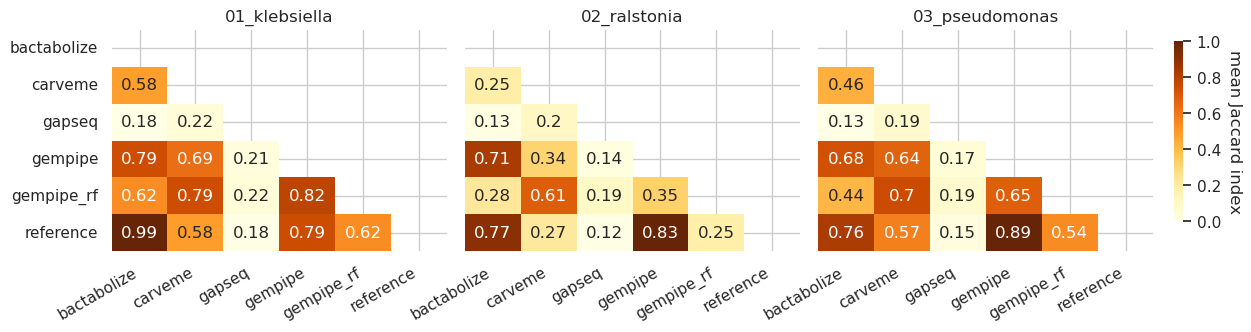

In [13]:
sb.set_theme(style="whitegrid")
        

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    triangular  = np.triu(np.ones_like(d ))
    sb.heatmap(d, mask=triangular,  cmap="YlOrBr", annot=True, **kwargs)
    
    
g = sb.FacetGrid(corr_matrix, col='dataset', height=4)
g.map_dataframe(draw_heatmap, 'tool1', 'tool2', 'value', cbar=False, square=False)


axes = g.axes.flatten()
axes[0].set_title("01_klebsiella")
axes[1].set_title("02_ralstonia")
axes[2].set_title("03_pseudomonas")

g.set_axis_labels('', '')

g.set_xticklabels(rotation=30, ha='right')


# show a colormap 
ax3 = g.fig.add_axes([0.96, 0.4, 0.05, 0.5])  # [left, bottom, width, height]
ax3.set_facecolor('none')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
cmap = plt.get_cmap('YlOrBr')  # Colormap
norm = mpl.colors.Normalize(vmin=0, vmax=1)  
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy data array, not used but required
cbar = plt.colorbar(sm, ax=ax3, orientation='vertical')
cbar.outline.set_visible(False)
cbar.set_label('mean Jaccard index', rotation=270, labelpad=15)

g

# plot orphan reactions

In [20]:
relative = True    # if True, the value is normalized to the number of metabolic reactions in the model

df = contents_all[contents_all['metric'].isin(['metR', 'orpR'])].copy()

if relative:   
    for index, row in df.iterrows(): 
        if row['metric'] == 'orpR': 

            n_metR = df[ \
                (df['strain']==row['strain']) & \
                (df['dataset']==row['dataset']) & \
                (df['tool']==row['tool']) & \
                (df['metric']=='metR') \
            ]['value_len'].iloc[0]    

            df.at[index, 'value_len'] =  df.loc[index, 'value_len'] / n_metR * 100
            df.at[index, 'value_len_inter'] =  df.loc[index, 'value_len_inter'] / n_metR * 100
        


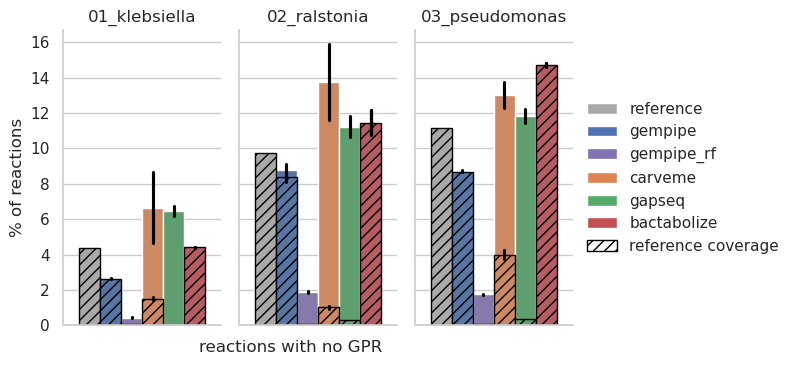

In [21]:
df = df[df['metric'].isin(['orpR'])]

sb.set_theme(style="whitegrid")

palette1 = {'reference': 'darkgrey', 'gempipe': 'C0', 'gempipe_rf': 'C4', 'carveme': 'C1', 'gapseq': 'C2', 'bactabolize': 'C3'}
g = sb.FacetGrid(df, col="dataset", height=4, aspect=0.5)
g = g.map_dataframe(sb.barplot, x='metric', y='value_len', hue='tool', palette=palette1, edgecolor='white', errorbar='sd', err_kws={'color': 'black'})
g = g.map_dataframe(sb.barplot, x='metric', y='value_len_inter', hue='tool', palette=palette1, edgecolor='black', errorbar='sd', err_kws={'color': 'black'})


for dataset in g.axes:
    for ax in dataset:
        for bars in ax.containers[int(len(ax.containers)/2):]:
            for bar in bars:
                bar.set_hatch('///')

                
if relative: g.set_axis_labels('', '% of reactions')
else : g.set_axis_labels('', 'number of reactions')


axes = g.axes.flatten()
axes[0].set_title("01_klebsiella")
axes[1].set_title("02_ralstonia")
axes[2].set_title("03_pseudomonas")


# remove x-axis labels
for ax in axes:
    ax.set_xticks([]) 
# add global x-axis label
g.fig.text(0.5, 0.1, 'reactions with no GPR', ha='center')


# custom legend: 
plt.legend()
patches = [Patch(facecolor=value, edgecolor='white', label=key) for key, value in palette1.items()]
hatched_patch = Patch(facecolor='none', edgecolor='black', hatch='///', label='reference coverage')
patches = patches + [hatched_patch]
legend = plt.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_frame_on(False)

g